In [447]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torchvision import transforms

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import os
from PIL import Image

In [448]:
is_gpu_available = torch.cuda.is_available()
print(is_gpu_available)

True


Data preparation 



In [449]:
csv_file_path = r'C:\Users\hazem\OneDrive\Desktop\simulator\simulator-windows-64\final_Data\driving_log.csv'

In [450]:
df = pd.read_csv(csv_file_path, header=None ,names=['center', 'left', 'right', 'wheel_rotation', 'throttle', 'brake', 'speed'])

In [451]:
df.head()

,center,left,right,wheel_rotation,throttle,brake,speed
0,C:\Users\hazem\OneDrive\Desktop\simulator\simu...,C:\Users\hazem\OneDrive\Desktop\simulator\sim...,C:\Users\hazem\OneDrive\Desktop\simulator\sim...,0.0,0.0,0.0,0.000078
1,C:\Users\hazem\OneDrive\Desktop\simulator\simu...,C:\Users\hazem\OneDrive\Desktop\simulator\sim...,C:\Users\hazem\OneDrive\Desktop\simulator\sim...,0.0,0.0,0.0,0.000078
2,C:\Users\hazem\OneDrive\Desktop\simulator\simu...,C:\Users\hazem\OneDrive\Desktop\simulator\sim...,C:\Users\hazem\OneDrive\Desktop\simulator\sim...,0.0,0.0,0.0,0.000081
3,C:\Users\hazem\OneDrive\Desktop\simulator\simu...,C:\Users\hazem\OneDrive\Desktop\simulator\sim...,C:\Users\hazem\OneDrive\Desktop\simulator\sim...,0.0,0.0,0.0,0.000078
4,C:\Users\hazem\OneDrive\Desktop\simulator\simu...,C:\Users\hazem\OneDrive\Desktop\simulator\sim...,C:\Users\hazem\OneDrive\Desktop\simulator\sim...,0.0,0.0,0.0,0.000079


In [452]:
df.isnull().sum()

center            0
left              0
right             0
wheel_rotation    0
throttle          0
brake             0
speed             0
dtype: int64

In [453]:
df.shape

(3903, 7)

In [455]:
# reading the images according to the path in the df data frame
def read_img(path):
    img = Image.open(path.strip())
    return np.asarray(img)

In [456]:
# reading the center, left and right images
center_images, left_images, right_images = [df[col].apply(read_img) for col in ["center", "left", "right"]]

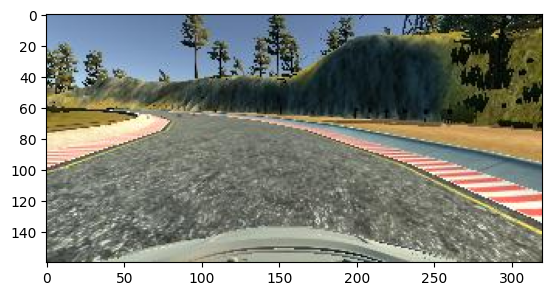

<class 'numpy.ndarray'>


In [457]:
#plot to check the images and check type
plt.imshow(center_images[0])
plt.show()
print(type(center_images[0]))

In [458]:
# convert from series to numpy array
center_images_array = np.asarray(center_images.tolist())
right_images_array = np.asarray(right_images.tolist())
left_images_array = np.asarray(left_images.tolist())
center_images_array.shape, right_images_array.shape, left_images_array.shape

((3903, 160, 320, 3), (3903, 160, 320, 3), (3903, 160, 320, 3))

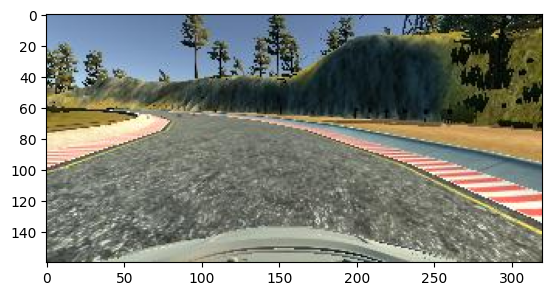

In [459]:
plt.imshow(center_images_array[0])

In [460]:
num_of_images,rows,columns,channels = center_images_array.shape
num_of_images,rows,columns,channels

(3903, 160, 320, 3)

In [461]:
#split data
X_train, X_test, y_train, y_test = train_test_split(
    center_images,
    df[["wheel_rotation", "throttle"]],
    test_size=0.2,
    random_state=42
)

rotation_train = y_train["wheel_rotation"]
throttle_train = y_train["throttle"]
rotation_test = y_test["wheel_rotation"]
throttle_test = y_test["throttle"]

In [462]:
#check shapes 
rotation_train.shape, throttle_train.shape, rotation_test.shape, throttle_test.shape   

((3122,), (3122,), (781,), (781,))

In [463]:
#convert to numpy array
X_train = np.asarray(X_train.tolist())
X_test = np.asarray(X_test.tolist())
rotation_train = np.asarray(rotation_train.tolist())
throttle_train = np.asarray(throttle_train.tolist())
rotation_test = np.asarray(rotation_test.tolist())
throttle_test = np.asarray(throttle_test.tolist())



In [464]:
#check shapes
X_train.shape , X_test.shape,rotation_train.shape, throttle_train.shape, rotation_test.shape, throttle_test.shape

((3122, 160, 320, 3), (781, 160, 320, 3), (3122,), (3122,), (781,), (781,))

Model Design


In [465]:
class SelfDrivingModel(nn.Module):
    def __init__(self):
        super(SelfDrivingModel, self).__init__()
        # Define your neural network layers here
        self.conv1 = nn.Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
        self.conv2 = nn.Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
        self.conv3 = nn.Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
        self.conv4 = nn.Conv2d(48, 64, kernel_size=(1, 1))  # Reduced kernel size
        self.conv5 = nn.Conv2d(64, 64, kernel_size=(1, 1))  # Reduced kernel size
        
        # MaxPooling layers
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        # Fully connected layers
        self.fc1 = nn.Linear(256, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)
        self.fc4 = nn.Linear(10, 1)

    def forward(self, x):
        # Forward pass through convolutional layers
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.relu(self.conv3(x))
        x = self.pool3(x)
        x = torch.relu(self.conv4(x))  # Use the smaller kernel size
        x = torch.relu(self.conv5(x))
        
        # Flatten the output
        x = x.view(x.size(0), -1)
        
        # Forward pass through fully connected layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # Linear output (steering angle)
        
        return x


In [466]:
#make an instance of the model
model = SelfDrivingModel()


In [467]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [468]:
X_train = X_train.transpose(0,3,1,2)
X_test = X_test.transpose(0,3,1,2)

In [469]:
mean = np.mean(X_train,axis =0)
std = np.std(X_train,axis =0)

X_train = (X_train - mean)/std

mean = np.mean(X_test,axis =0)
std = np.std(X_test,axis =0)

X_test = (X_test - mean)/std

In [470]:
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(rotation_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(rotation_test))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)


In [471]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


SelfDrivingModel(
  (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
  (conv3): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
  (conv4): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
)

In [472]:
train_losses = []
# Training loop
for epoch in range(50):
    train_loss = 0.0

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.float().to(device)  # Ensure input data is a float tensor
        batch_y =  batch_y.float().to(device) # Ensure target data is a float tensor

        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass through the model
        outputs = model(batch_x)

        # Calculate the loss
        loss = criterion(outputs, batch_y)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Calculate and print the average training loss for the epoch
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch + 1}/{50}] - Train Loss: {avg_train_loss:.4f}')


c:\Users\hazem\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\hazem\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/50] - Train Loss: 0.0236
Epoch [2/50] - Train Loss: 0.0198
Epoch [3/50] - Train Loss: 0.0192
Epoch [4/50] - Train Loss: 0.0189
Epoch [5/50] - Train Loss: 0.0188
Epoch [6/50] - Train Loss: 0.0190
Epoch [7/50] - Train Loss: 0.0189
Epoch [8/50] - Train Loss: 0.0188
Epoch [9/50] - Train Loss: 0.0189
Epoch [10/50] - Train Loss: 0.0188
Epoch [11/50] - Train Loss: 0.0188
Epoch [12/50] - Train Loss: 0.0188
Epoch [13/50] - Train Loss: 0.0187
Epoch [14/50] - Train Loss: 0.0188
Epoch [15/50] - Train Loss: 0.0188
Epoch [16/50] - Train Loss: 0.0185
Epoch [17/50] - Train Loss: 0.0187
Epoch [18/50] - Train Loss: 0.0186
Epoch [19/50] - Train Loss: 0.0188
Epoch [20/50] - Train Loss: 0.0185
Epoch [21/50] - Train Loss: 0.0185
Epoch [22/50] - Train Loss: 0.0185
Epoch [23/50] - Train Loss: 0.0186
Epoch [24/50] - Train Loss: 0.0186
Epoch [25/50] - Train Loss: 0.0185
Epoch [26/50] - Train Loss: 0.0186
Epoch [27/50] - Train Loss: 0.0185
Epoch [28/50] - Train Loss: 0.0185
Epoch [29/50] - Train Loss: 0

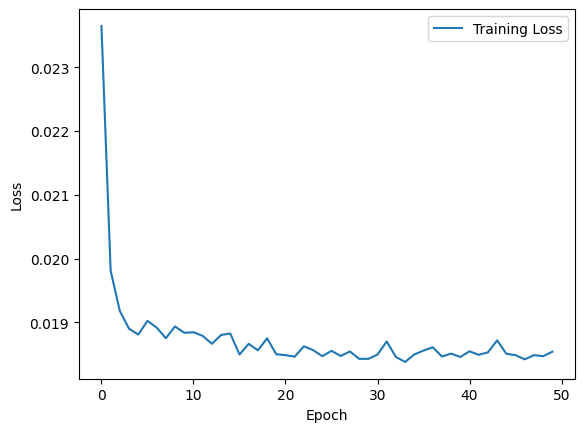

In [473]:
# Visualize the training loss
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [478]:
# Test the model
model.eval()  # Set model to evaluation mode
test_loss = 0.0
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.float().to(device)  # Ensure input data is a float tensor
        batch_y = batch_y.float().to(device)  # Ensure target data is a float tensor

        # Forward pass through the model
        outputs = model(batch_x)

        # Calculate the loss
        loss = criterion(outputs, batch_y)

        # Update test loss 
        test_loss += loss.item()

        
    # Calculate and print the average test loss
    avg_test_loss = test_loss / len(test_loader)
    print(f'Test Loss: {avg_test_loss:.4f}')

    # Calculate and print the accuracy


Test Loss: 0.0161


In [475]:
# Save the model
torch.save(model.state_dict(), 'model.pth')